#### The classification goal is to predict if the client will subscribe a term deposit using KNN classification algorithm. You can use PCA technique as a dimension reduction measure. Its application has already been taught in the previous class

In [19]:
import pandas as pd
import numpy as np

In [20]:
bank=pd.read_csv('bank-additional-full.csv',sep=';')

In [21]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [22]:
bank = bank.drop(columns=["duration"])

In [23]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(4), object(11)
memory usage: 6.3+ MB


In [24]:
# class distribution
bank.groupby("y").size()

y
no     36548
yes     4640
dtype: int64

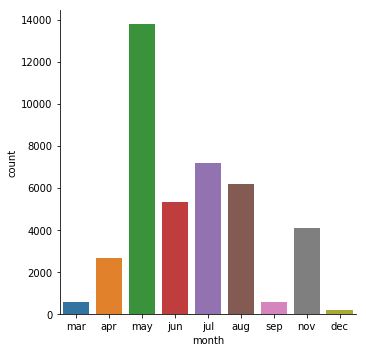

In [26]:
#  The classes are imbalanced. The dataset needs to be resampled.
# Plotting some categorical variables
# show feature month - last contact month of year and count it
import seaborn as sns
sns.catplot(x="month", kind="count", data=bank,
            order=["mar", "apr", "may", "jun", "jul", "aug", "sep", "nov",
                   "dec"])
plt.show()

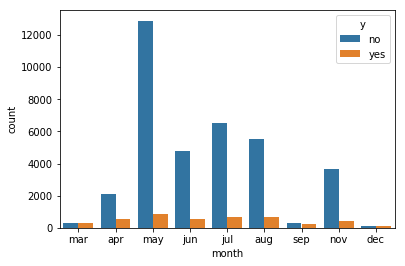

In [27]:
# count subscribed deposit per month
ax = sns.countplot(x="month", hue="y", data=bank,
                   order=["mar", "apr", "may", "jun", "jul", "aug", "sep",
                          "nov", "dec"])

plt.show()

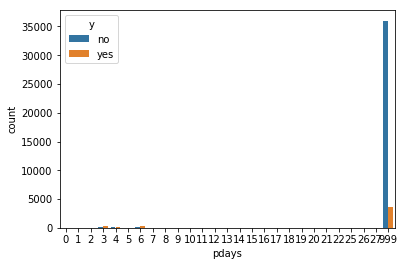

In [28]:
# pdays: number of days that passed by after the client was 
# last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
# count y
ax = sns.countplot(x="pdays", hue="y", data=bank)
plt.show()


In [29]:
# It seems to me that the variable "month" and "day_of_week" have no relevance for the prediction. For some reason, many calls were made in May. Most calls were made for the first time (999).
# Prepare Data
bank_enc = bank.copy()

# remove columns month and day_of_week
bank_enc = bank_enc.drop(columns=["month", "day_of_week"])


#### Encode categorical variable

In [32]:
# use scikit-learn LabelEncoder to encode labels
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
# Convert categorical variable
bank_enc = pd.get_dummies(bank_enc, columns=['job'], prefix=['job'])
bank_enc = pd.get_dummies(bank_enc,
                             columns=['marital'], prefix=['marital'])
bank_enc = pd.get_dummies(bank_enc,
                             columns=['education'], prefix=['education'])
bank_enc = pd.get_dummies(bank_enc,
                             columns=['default'], prefix=['default'])
bank_enc = pd.get_dummies(bank_enc,
                             columns=['housing'], prefix=['housing'])
bank_enc = pd.get_dummies(bank_enc, columns=['loan'], prefix=['loan'])

# binary transform of column contact categorical: "cellular","telephone"
bank_enc['contact'] = lb.fit_transform(bank['contact'])
bank_enc = pd.get_dummies(bank_enc,
                             columns=['poutcome'], prefix=['poutcome'])

# move y at end of bank
bank_enc['y_class'] = bank['y']

# remove original y column
bank_enc = bank_enc.drop(columns=["y"])
#View bank again

In [33]:
bank_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 47 columns):
age                              41188 non-null int64
contact                          41188 non-null int32
campaign                         41188 non-null int64
pdays                            41188 non-null int64
previous                         41188 non-null int64
emp.var.rate                     41188 non-null float64
cons.price.idx                   41188 non-null float64
cons.conf.idx                    41188 non-null float64
euribor3m                        41188 non-null float64
nr.employed                      41188 non-null float64
job_admin.                       41188 non-null uint8
job_blue-collar                  41188 non-null uint8
job_entrepreneur                 41188 non-null uint8
job_housemaid                    41188 non-null uint8
job_management                   41188 non-null uint8
job_retired                      41188 non-null uint8
job_self-employed

In [36]:
# Resample dataset - Down-sample Majority Class
from sklearn.utils import resample

bank_majority = bank_enc[bank_enc.y_class == "no"]
bank_minority = bank_enc[bank_enc.y_class == "yes"]

# Downsample majority class
df_majority_downsampled = resample(bank_majority, replace=False,
                                   n_samples=4640, random_state=123)

bank_downsampled = pd.concat([df_majority_downsampled, bank_minority])
bank_downsampled.y_class.value_counts()

no     4640
yes    4640
Name: y_class, dtype: int64

#### we now have a balanced dataset

#### Evaluate Algorithms

In [38]:
# Evaluate Algorithms
# Split-out validation bank
from sklearn.model_selection import train_test_split
array = bank_downsampled.values
X = array[:, 0:46]
Y = array[:, 46]
validation_size = 0.20
seed = 7

X_train, X_validation, Y_train, Y_validation = \
    train_test_split(X, Y, test_size=validation_size, random_state=seed)

# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

LR 0.731276 0.009660
KNN 0.696392 0.011014
CART 0.648708 0.012297
NB 0.703802 0.015245


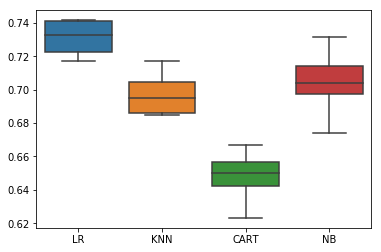

In [42]:
# Spot Check Algorithms
# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold,
                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name} {cv_results.mean():f} {cv_results.std():f}"
    print(msg)

# Compare Algorithms
sns.boxplot(x=names, y=results)
plt.show()

#### Logistic regression has the better result

#### Spot Check some ensemble Algorithms

AB 0.738417 0.016105
GBM 0.745151 0.013374


C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

RF 0.714844 0.011769


C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

ET 0.693965 0.013550


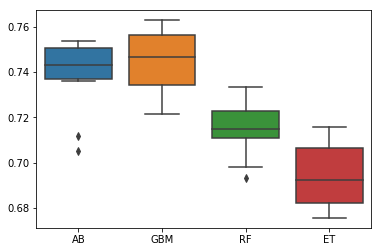

In [46]:
# Compare Algorithms
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
pipelines = []
pipelines.append(("AB",
                  Pipeline([("AB", AdaBoostClassifier())])))
pipelines.append(("GBM",
                  Pipeline([("GBM", GradientBoostingClassifier())])))
pipelines.append(("RF",
                  Pipeline([("RF", RandomForestClassifier())])))
pipelines.append(("ET",
                  Pipeline([("ET", ExtraTreesClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold,
                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name} {cv_results.mean():f} {cv_results.std():f}"
    print(msg)

# Compare Algorithms
sns.boxplot(x=names, y=results)
plt.show()

#### GradientBoostingClassifier has the better result

#### Finalize Model

Accuracy score: 0.7505387931034483
Classification report
              precision    recall  f1-score   support

          no       0.71      0.86      0.78       939
         yes       0.82      0.64      0.72       917

   micro avg       0.75      0.75      0.75      1856
   macro avg       0.76      0.75      0.75      1856
weighted avg       0.76      0.75      0.75      1856

Confusion Matrix:
[[810 129]
 [334 583]]


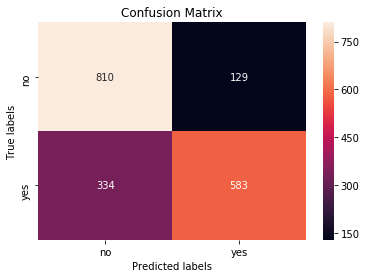

In [50]:
# Finalize Model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
model = GradientBoostingClassifier()
# prepare the model
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

print("Accuracy score:", accuracy_score(Y_validation, predictions))
print("Classification report")
print(classification_report(Y_validation, predictions))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_validation, predictions))
conf_mat = confusion_matrix(Y_validation, predictions)
ax = plt.subplot()
sns.heatmap(conf_mat, annot=True, ax=ax, fmt='d')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['no', 'yes'])
ax.yaxis.set_ticklabels(['no', 'yes'])
plt.show()